### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import namedtuple
from scipy.signal import butter, filtfilt
from scipy.io import loadmat
from collections import namedtuple
from math import floor
from scipy import stats
import antropy as ant
import spkit as sp
import seaborn as sns

import pywt
import warnings
from vmdpy import VMD
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

### Read and preprocess data

In [2]:
EEG_78_CH2 = pd.read_csv('EEG_78_CH2.csv')
bis_78 = pd.read_csv('bis_78.csv')
B78=bis_78['BIS/BIS']
E78=EEG_78_CH2['BIS/EEG2_WAV']
print ('The shape of EEG signals and BIS for patient 78 is {} and {} '.format(E78.shape,B78.shape) )
print ('The type of EEG signals and BIS for patient 78 is {} and {} '.format(type(E78),type(B78)) )

The shape of EEG signals and BIS for patient 78 is (535191,) and (4180,) 
The type of EEG signals and BIS for patient 78 is <class 'pandas.core.series.Series'> and <class 'pandas.core.series.Series'> 


In [3]:
#checking for missing values

def missing_values(eeg_signal):

    # Check for missing values
    missing_values = np.isnan(eeg_signal)
    length_signals = len(eeg_signal)

    # Count the number of missing values
    num_missing_values = np.sum(missing_values)
    percentage_missing_values = (num_missing_values/length_signals)*100

    # Print the indices and values of missing values
    missing_indices = np.where(missing_values)[0]
    missing_values_list = eeg_signal[missing_indices]

    print("Missing Values:")
    print(f"Total Missing Values: {num_missing_values}")
    print(f"Percentage of Missing Values: {percentage_missing_values} %")  
missing_values(E78)

Missing Values:
Total Missing Values: 167
Percentage of Missing Values: 0.03120381321808476 %


In [4]:
E78_copy = np.copy(E78)

In [5]:
# Handling missing values

def handle_missing_values(signal):
    # Interpolate missing values using linear interpolation
    mask = np.isnan(signal)
    signal[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), signal[~mask])
    return signal
E78_copy=handle_missing_values(E78_copy)

### Selecting EEG signals

In [23]:
import numpy as np

# Assuming BIS and EEG are numpy arrays
BIS = B78
EEG = E78_copy

# Define the sampling frequency
fs = 128

# Define the indices for BIS range from 200 to 800
bis_start_index = 60
bis_end_index = 3000

# Convert the BIS indices to EEG indices

eeg_start_index = bis_start_index * fs
eeg_end_index = bis_end_index * fs

# Select EEG values for BIS[200:800]
selected_EEG = EEG[eeg_start_index:eeg_end_index]
selected_bis = BIS[bis_start_index:bis_end_index]
selected_bis = np.array(selected_bis)
print(selected_EEG)


[-15.6   -9.35  -6.9  ... -13.25 -15.   -15.35]


### Bandpass filtering

In [24]:
# Define the EEG signal
eeg_signal = selected_EEG # Replace with your actual EEG signal


# Define the filter function
def bandpass_filter(signal, lowcut, highcut, fs, order=3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# time in seconds
time = np.arange(len(eeg_signal)) / fs

# Apply bandpass filters to the EEG signal
bpass = bandpass_filter(eeg_signal, 0.01, 63.5, fs=128)


### Variational Mode Decomposition (VMD)

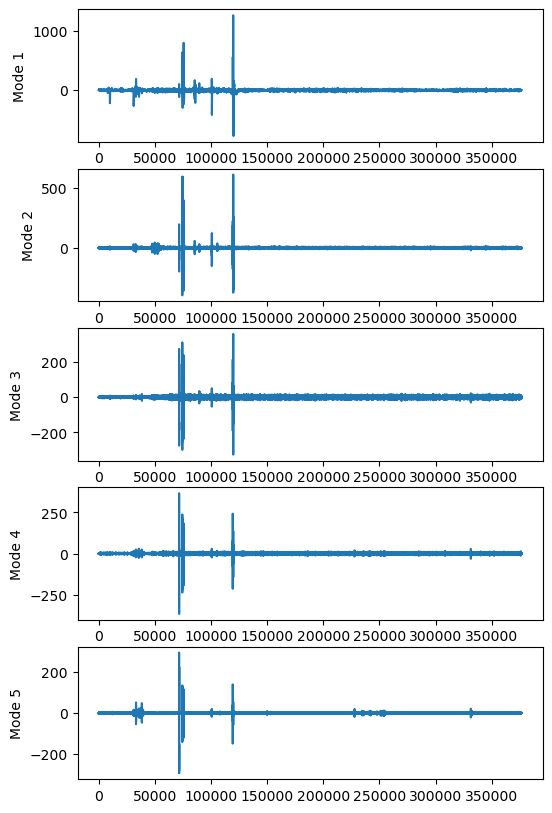

In [26]:


import numpy as np
from vmdpy import VMD

signal = bpass

# Set VMD parameters
alpha = 2000
tau = 0.5
K = 5
DC = 0
init = 1           # initialize omegas uniformly  
tol = 1e-7 

# Run VMD on the signal
modes, spectrum, omega =VMD (signal, alpha, tau, K, DC, init,tol)

#Plot the decomposed modes
import matplotlib.pyplot as plt
fig, axs = plt.subplots(K, 1, figsize=(6, 10))
for i in range(K):
    axs[i].plot(modes[i, :])
    axs[i].set_ylabel(f"Mode {i+1}")
plt.show()

### Windowing and features extraction

In [ ]:
# For BIS

def moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    windows = []

    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end][0]
        windows.append(window)

    return windows

# Example usage
data = selected_bis  # Sample data
window_size_sec = 56.0       # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 1         # Sampling rate in samples per second

# Apply moving sliding window
bis_windows = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate)

# Print the number of windows and the shape of the first window
print("Number of BIS:", len(bis_windows))
plt.plot(bis_windows)
plt.show()


In [ ]:
# For mean and standard deviation

def moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    
    windows = []
    
    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end]
        windows.append(window)
        #window_start += stride
        
        
        if method == "mean":
            # Calculate sample entropy within the window
            results = np.mean(windows, axis=1)
            


        if method == "std":
            # Calculate sample entropy within the window
            results = np.std(windows, axis=1)

    return results

In [ ]:
# Example usage
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]


# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second
# Apply moving sliding window and calculate sample entropies
result_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='std')
result_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='std')
result_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='std')
result_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='std')
result_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='std')
    
print(f"Number of features:", len(result_0))

In [12]:
print(f"Number of features:", len(result_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(result_0)
axes[0, 0].set_title('Std_mode 0')

# Plot on the second subplot
axes[0, 1].plot(result_1)
axes[0, 1].set_title('Std_mode 1')

# Plot on the third subplot
axes[0, 2].plot(result_2)
axes[0, 2].set_title('Std_mode 2')

axes[1, 0].plot(result_3)
axes[1, 0].set_title('Std_mode 3')

axes[1, 1].plot(result_4)
axes[1, 1].set_title('Std_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


NameError: name 'result_4' is not defined

In [27]:
#### For entropies

def moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    
    result = []
    
    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end]
        
        
        if method == "sample entropy":
            # Calculate sample entropy within the window
            sample_entropy = ant.sample_entropy(window)
            result.append(sample_entropy)


        if method == "Permutation entropy":
            # Calculate sample entropy within the window
            permutation_entropy = ant.perm_entropy(window)
            result.append(permutation_entropy)
            
        if method == "Dispersion entropy":
            # Calculate sample entropy within the window
            Dispersion_entropy, prob = sp.dispersion_entropy(window,classes=5, scale=3, emb_dim=3, delay=1,return_all=False)
            result.append(Dispersion_entropy)

    return result


In [14]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128 


resultsa_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='sample entropy')
resultsa_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='sample entropy')
resultsa_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='sample entropy')
resultsa_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='sample entropy')
resultsa_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='sample entropy')
print(f"Number of features:", len(resultsa_0))



Number of features: 2945


Number of features: 2945


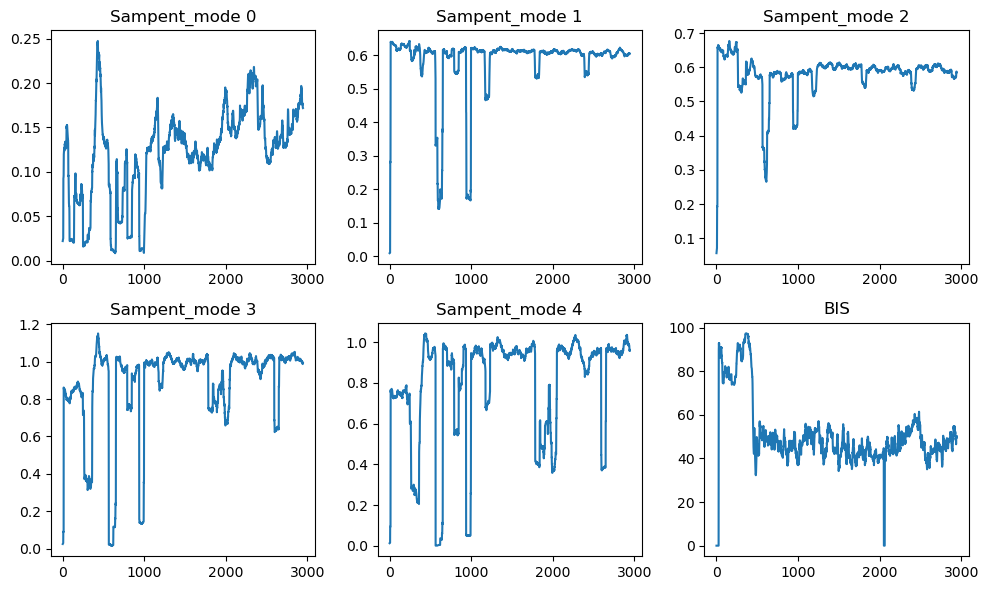

In [16]:
print(f"Number of features:", len(result_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsa_0)
axes[0, 0].set_title('Sampent_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsa_1)
axes[0, 1].set_title('Sampent_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsa_2)
axes[0, 2].set_title('Sampent_mode 2')

axes[1, 0].plot(resultsa_3)
axes[1, 0].set_title('Sampent_mode 3')

axes[1, 1].plot(resultsa_4)
axes[1, 1].set_title('Sampent_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


In [28]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128        # Sampling rate in samples per second


# Apply moving sliding window and calculate sample entropies
resultsp_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')
resultsp_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')
resultsp_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')
resultsp_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')
resultsp_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')

print(f"Number of features:", len(resultsp_0))


Number of features: 2885


Number of features: 2885


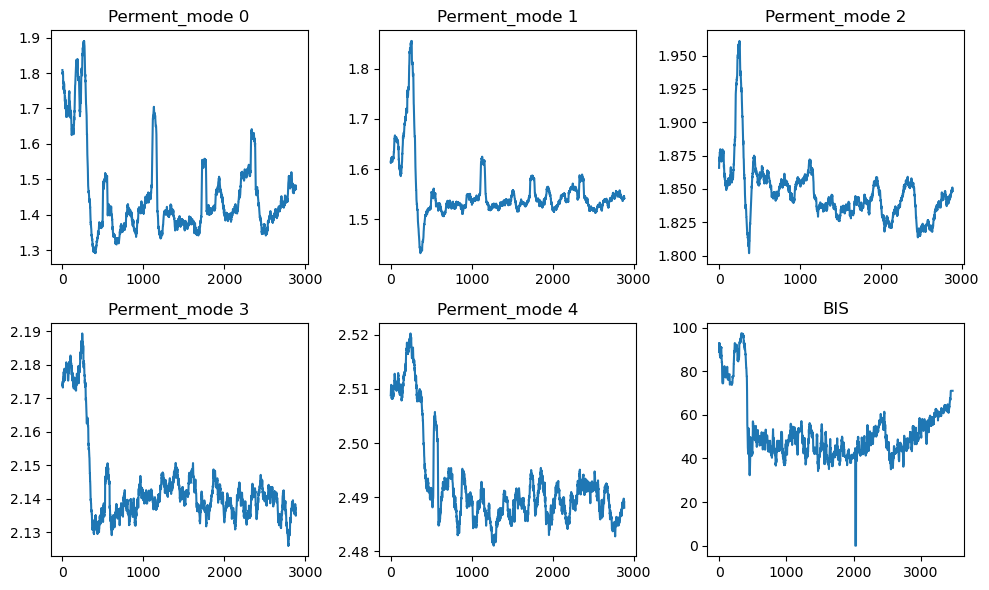

In [29]:
print(f"Number of features:", len(resultsp_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsp_0)
axes[0, 0].set_title('Perment_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsp_1)
axes[0, 1].set_title('Perment_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsp_2)
axes[0, 2].set_title('Perment_mode 2')

axes[1, 0].plot(resultsp_3)
axes[1, 0].set_title('Perment_mode 3')

axes[1, 1].plot(resultsp_4)
axes[1, 1].set_title('Perment_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


In [ ]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128        # Sampling rate in samples per second

# Apply moving sliding window and calculate sample entropies
resultsd_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
resultsd_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
resultsd_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
resultsd_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
resultsd_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
print(f"Number of features:", len(resultsd_0))


Number of features: 2945


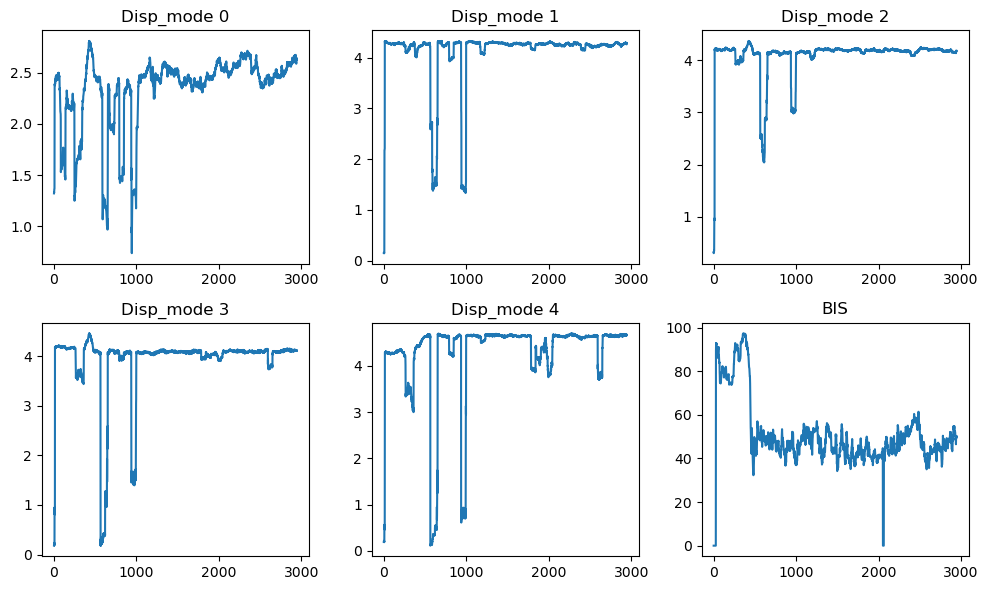

In [20]:
print(f"Number of features:", len(result_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsd_0)
axes[0, 0].set_title('Disp_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsd_1)
axes[0, 1].set_title('Disp_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsd_2)
axes[0, 2].set_title('Disp_mode 2')

axes[1, 0].plot(resultsd_3)
axes[1, 0].set_title('Disp_mode 3')

axes[1, 1].plot(resultsd_4)
axes[1, 1].set_title('Disp_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


### Create Dataframe for each feature and find the correlation


In [22]:
# Standard deviation

df_std = pd.DataFrame({'Std_mode0': result_0, 'Std_mode1': result_1, 'Std_mode2': result_2, 'Std_mode3': result_3, 'Std_mode4': result_4})

df_std['BIS']=bis_windows
df_std

,Std_mode0,Std_mode1,Std_mode2,Std_mode3,Std_mode4,BIS
0,28.923394,25.845663,15.301042,16.528876,23.758930,0.0
1,28.935608,25.846493,15.302558,16.529606,23.759449,0.0
2,28.939532,25.847296,15.303974,16.531565,23.760629,0.0
3,28.953636,25.847821,15.304828,16.531996,23.761269,0.0
4,28.964303,25.848707,15.307640,16.533664,23.761692,0.0
...,...,...,...,...,...,...
2940,6.712942,3.840503,4.110885,0.817430,0.433893,49.9
2941,6.736045,3.801348,4.100186,0.822976,0.433094,49.2
2942,6.759760,3.808994,4.010513,0.818387,0.435001,50.2
2943,6.780330,3.766968,4.043785,0.817563,0.431493,49.9


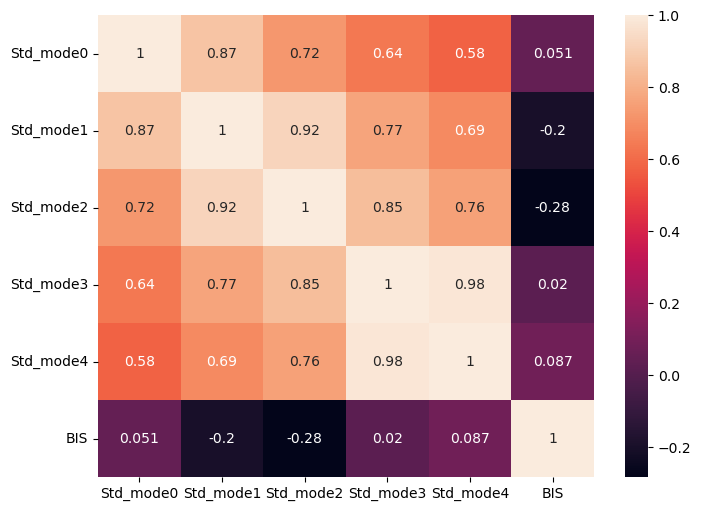

In [23]:
plt.figure(figsize=(8,6))
sns.heatmap(df_std.corr(), annot = True)
plt.show()

In [24]:
# Sample entropy

df_samp = pd.DataFrame({'Sampent_mode0': resultsa_0, 'Sampent_mode1': resultsa_1, 'Sampent_mode2': resultsa_2, 'Sampent_mode3': resultsa_3, 'Sampent_mode4': resultsa_4})

df_samp['BIS']=bis_windows
df_samp

,Sampent_mode0,Sampent_mode1,Sampent_mode2,Sampent_mode3,Sampent_mode4,BIS
0,0.022060,0.008737,0.056206,0.025139,0.012788,0.0
1,0.022914,0.008946,0.058478,0.025873,0.013016,0.0
2,0.023150,0.009123,0.061092,0.027148,0.013679,0.0
3,0.023801,0.009242,0.062633,0.027579,0.013970,0.0
4,0.024291,0.009533,0.067275,0.028744,0.014154,0.0
...,...,...,...,...,...,...
2940,0.176441,0.604111,0.584491,0.993368,0.969684,49.9
2941,0.174533,0.603120,0.584245,0.986863,0.967025,49.2
2942,0.174317,0.602795,0.587475,0.987052,0.958171,50.2
2943,0.171909,0.603928,0.585579,0.988152,0.962918,49.9


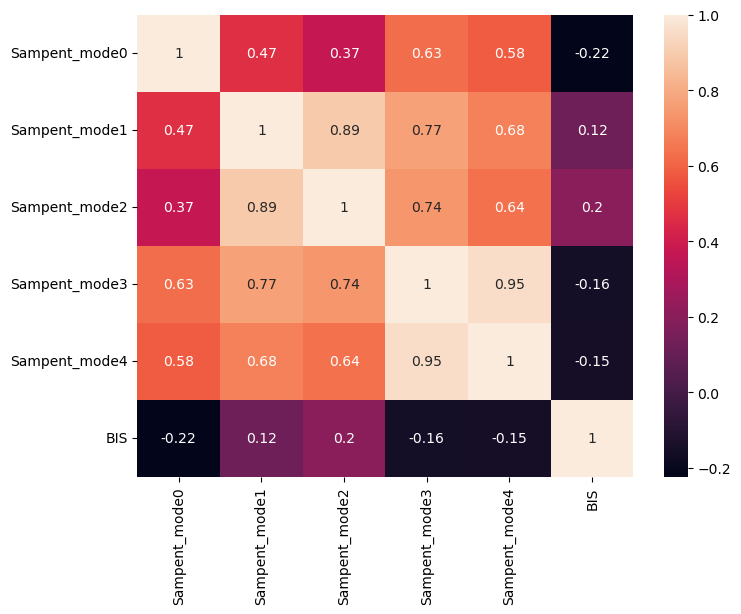

In [25]:
plt.figure(figsize=(8,6))
sns.heatmap(df_samp.corr(), annot = True)
plt.show()

In [26]:
# Permutation entropy

df_perm = pd.DataFrame({'Perment_mode0': resultsp_0, 'Perment_mode1': resultsp_1, 'Perment_mode2': resultsp_2, 'Perment_mode3': resultsp_3, 'Perment_mode4': resultsp_4})

df_perm['BIS']=bis_windows
df_perm

,Perment_mode0,Perment_mode1,Perment_mode2,Perment_mode3,Perment_mode4,BIS
0,1.743072,1.854241,2.071490,2.448606,2.571438,0.0
1,1.739380,1.853760,2.067920,2.447942,2.571412,0.0
2,1.737309,1.851582,2.068266,2.447946,2.571552,0.0
3,1.731726,1.850233,2.067870,2.448284,2.571507,0.0
4,1.712957,1.849733,2.068564,2.447973,2.571454,0.0
...,...,...,...,...,...,...
2940,1.414004,1.779230,1.969219,2.409916,2.560056,49.9
2941,1.409999,1.778741,1.970419,2.409795,2.560024,49.2
2942,1.405934,1.777264,1.970422,2.410176,2.560152,50.2
2943,1.408690,1.778692,1.969225,2.410116,2.560278,49.9


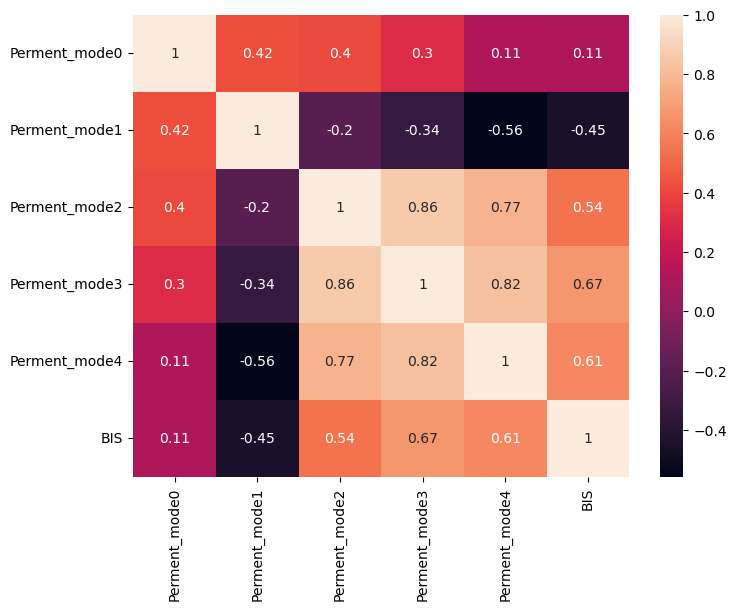

In [27]:
plt.figure(figsize=(8,6))
sns.heatmap(df_perm.corr(), annot = True)
plt.show()

In [28]:
# Dispersion entropy

df_disp = pd.DataFrame({'Disp_mode0': resultsd_0, 'Disp_mode1': resultsd_1, 'Disp_mode2': resultsd_2, 'Disp_mode3': resultsd_3, 'Disp_mode4': resultsd_4})

df_disp['BIS']=bis_windows
df_disp

,Disp_mode0,Disp_mode1,Disp_mode2,Disp_mode3,Disp_mode4,BIS
0,1.320013,0.150739,0.311860,0.185854,0.192169,0.0
1,1.330368,0.152843,0.297117,0.209716,0.217358,0.0
2,1.326525,0.145547,0.323121,0.182768,0.199659,0.0
3,1.350350,0.150739,0.319690,0.185854,0.192169,0.0
4,1.364287,0.152843,0.315762,0.238543,0.217358,0.0
...,...,...,...,...,...,...
2940,2.626317,4.275632,4.173966,4.106143,4.676092,49.9
2941,2.634466,4.282085,4.185952,4.110467,4.664384,49.2
2942,2.645789,4.258943,4.168988,4.105489,4.655406,50.2
2943,2.637017,4.275393,4.174937,4.103317,4.678678,49.9


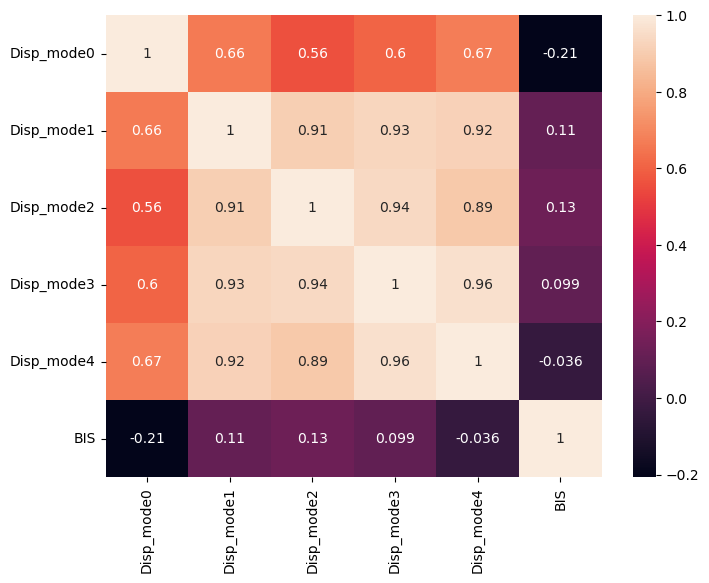

In [29]:
plt.figure(figsize=(8,6))
sns.heatmap(df_disp.corr(), annot = True)
plt.show()

In [30]:
metrics = {}
def plot_regression(data, column, normalize=False):
    
    global metrics
    
    X = data[column].values.reshape(-1, 1)
    y = data['BIS']

    # Perform regression
    reg = LinearRegression(n_jobs=-1).fit(X, y)
    
    # Predictions
    y_predicted = reg.predict(X)
    
    # Show the score and r2
    #mse = mean_squared_error(y, y_predicted)
    r2 = r2_score(y, y_predicted)
    
    # keep track of metrics
    
    #metrics["{}_mse".format(column)] = mse
    metrics["{}_r2".format(column)] = r2
    
    
    # Plot the graph
    plt.figure(figsize=(10,8))
    plt.scatter(data[column], data['BIS'], label="Data", c="steelblue")
    plt.plot(X, y_predicted, label="Regression", c="red")
    plt.xlabel(column)
    plt.ylabel('BIS')
    plt.legend(loc="upper left")
    plt.show()

In [31]:
df_jo=pd.DataFrame({'Perment_mode3': resultsp_3, 'Perment_mode4': resultsp_4,'Std_mode3': result_3, 'Std_mode2': result_2, 'Sampent_mode2': resultsa_2, 'Sampent_mode3': resultsa_3})

df_jo['BIS']=bis_windows
df_jo.head()

,Perment_mode3,Perment_mode4,Std_mode3,Std_mode2,Sampent_mode2,Sampent_mode3,BIS
0,2.448606,2.571438,16.528876,15.301042,0.056206,0.025139,0.0
1,2.447942,2.571412,16.529606,15.302558,0.058478,0.025873,0.0
2,2.447946,2.571552,16.531565,15.303974,0.061092,0.027148,0.0
3,2.448284,2.571507,16.531996,15.304828,0.062633,0.027579,0.0
4,2.447973,2.571454,16.533664,15.307640,0.067275,0.028744,0.0


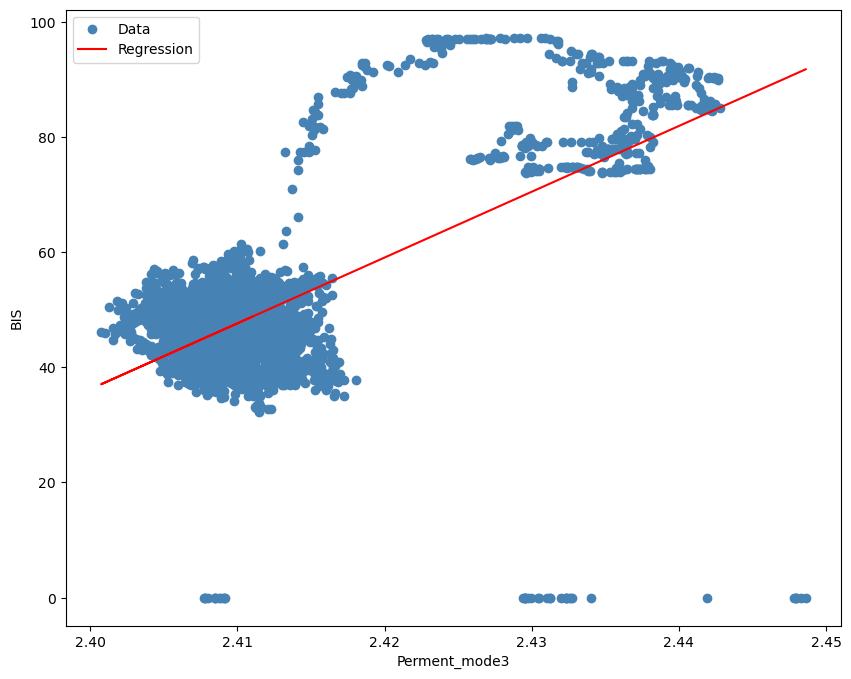

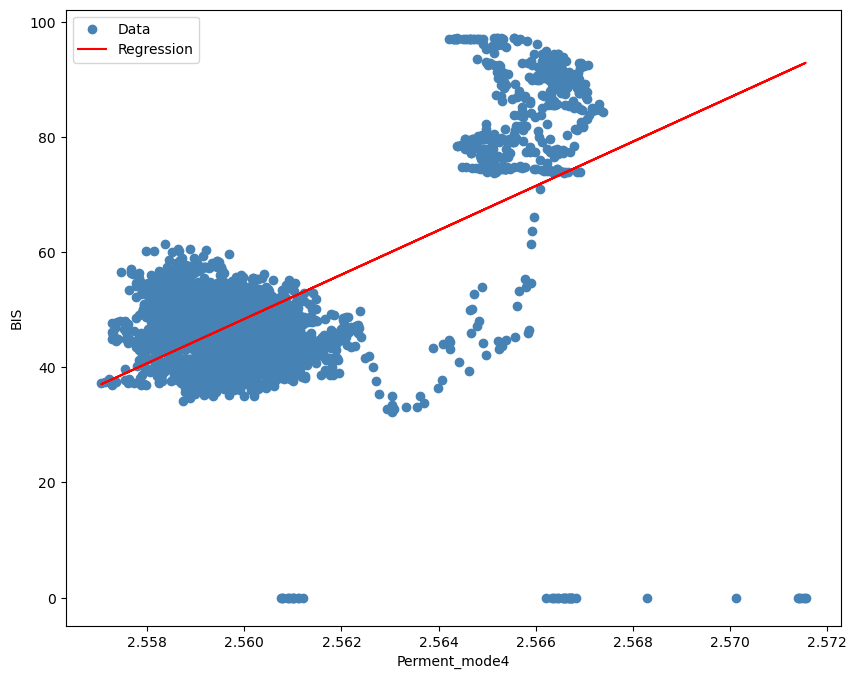

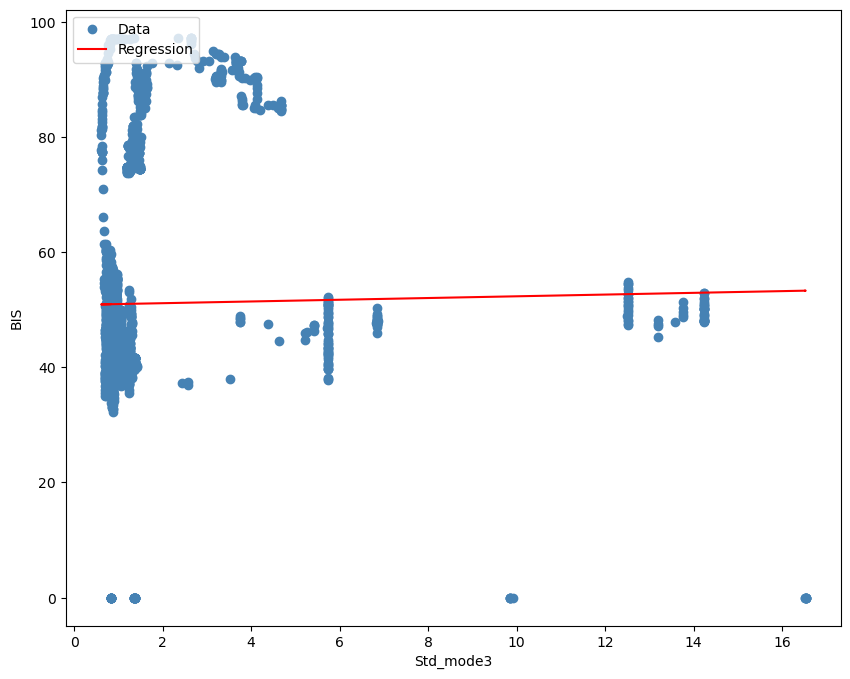

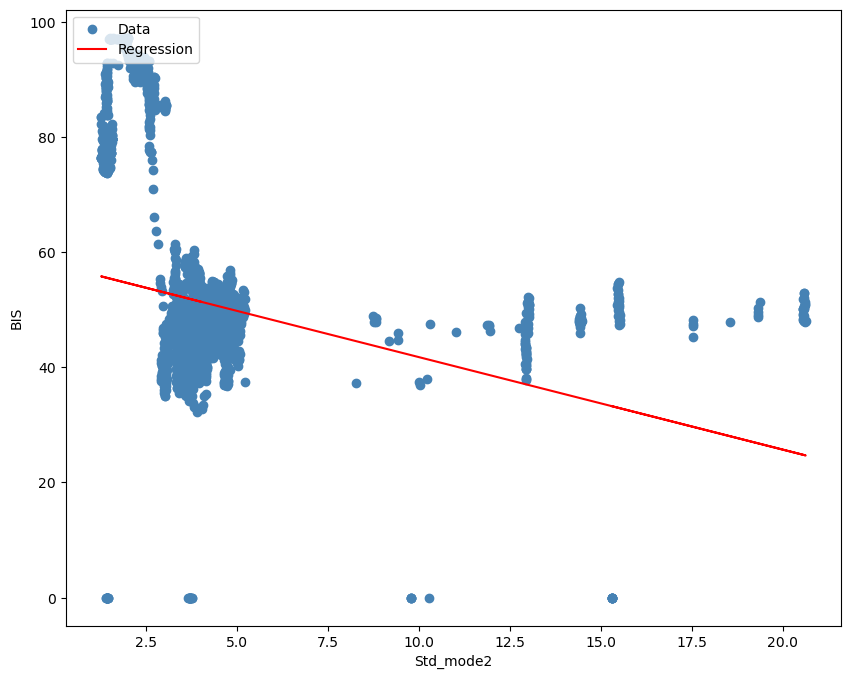

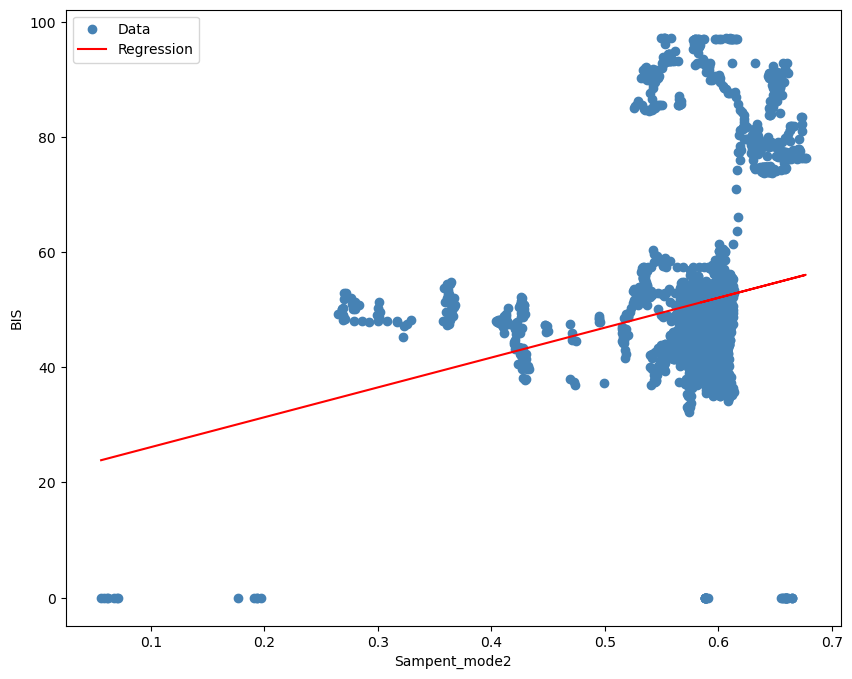

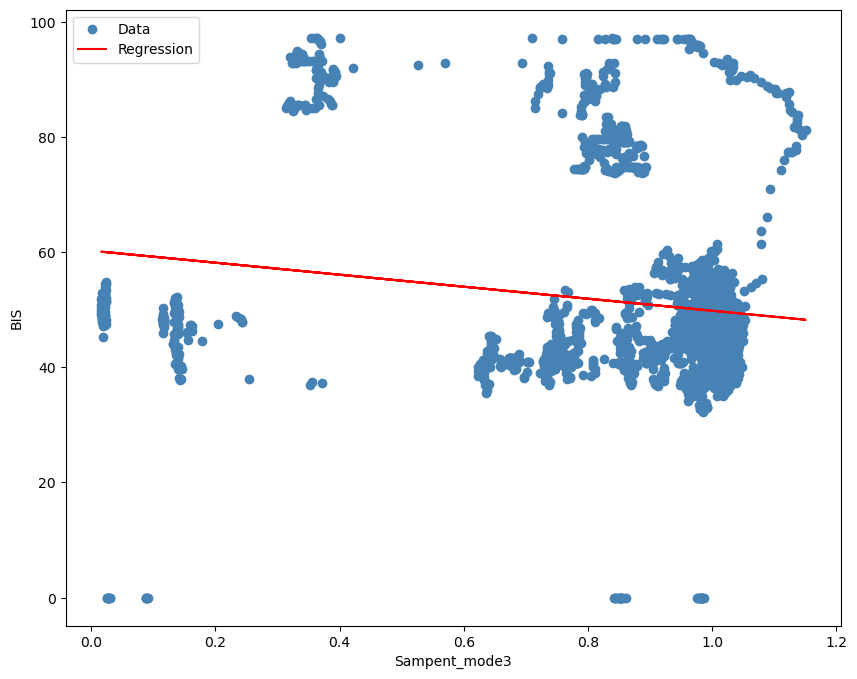

In [32]:
for column in df_jo.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_jo, column)

In [33]:
# Metrics
pd.DataFrame({"Metrics": [key for key in metrics.keys()], "Values": [value*100 for value in metrics.values()]})

,Metrics,Values
0,Perment_mode3_r2,44.800434
1,Perment_mode4_r2,37.534642
2,Std_mode3_r2,0.040697
3,Std_mode2_r2,8.088898
4,Sampent_mode2_r2,4.077400
5,Sampent_mode3_r2,2.502117


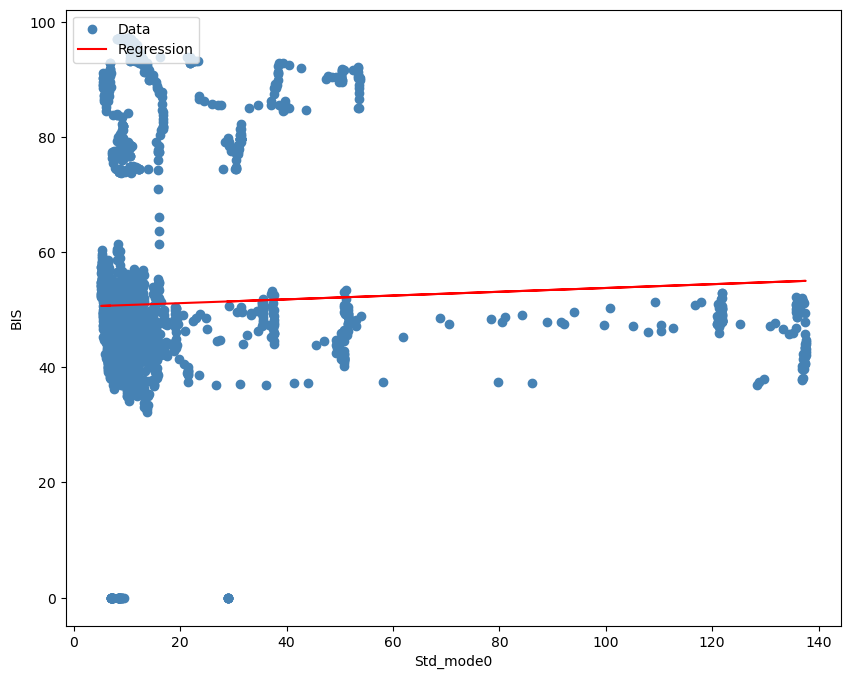

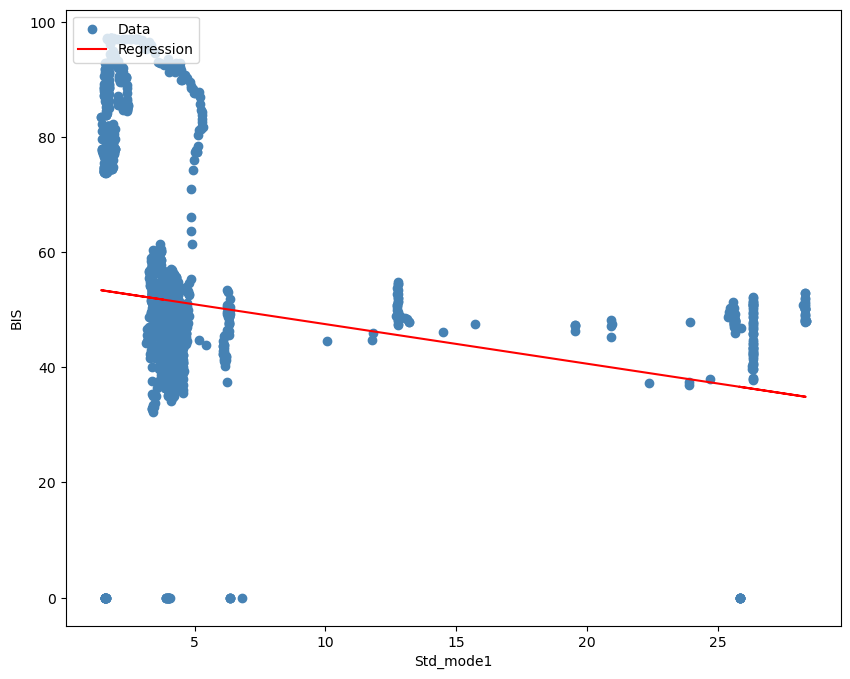

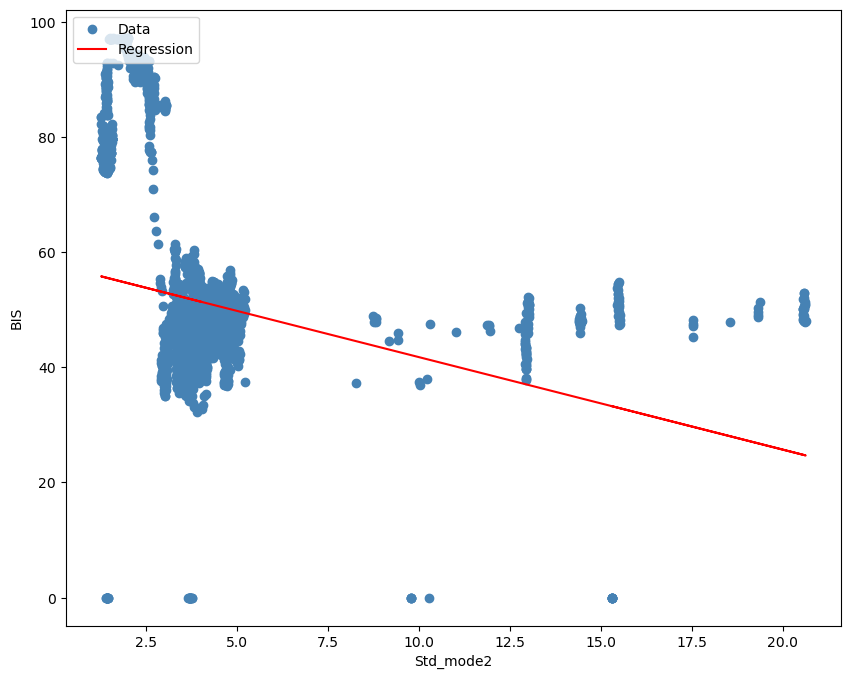

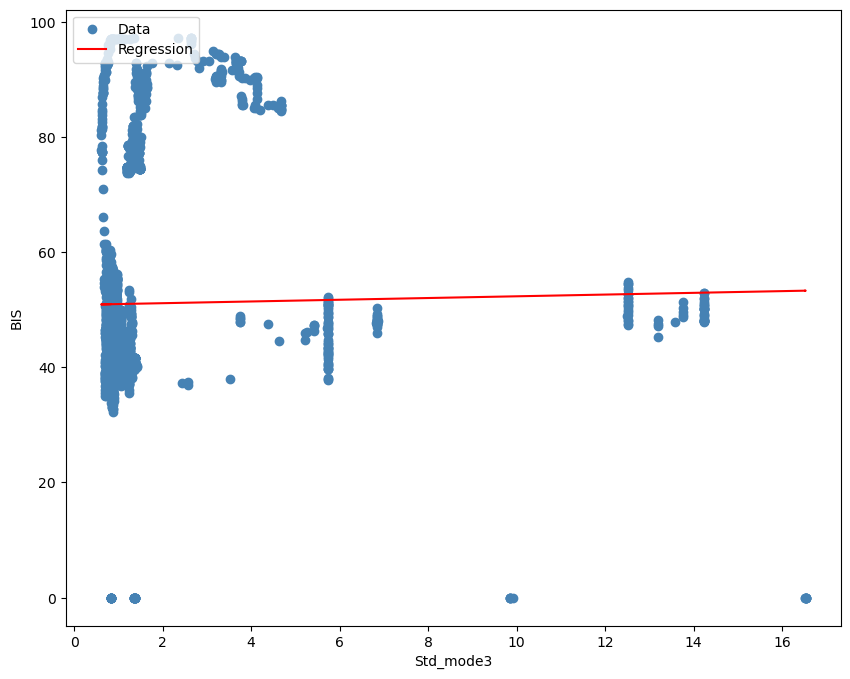

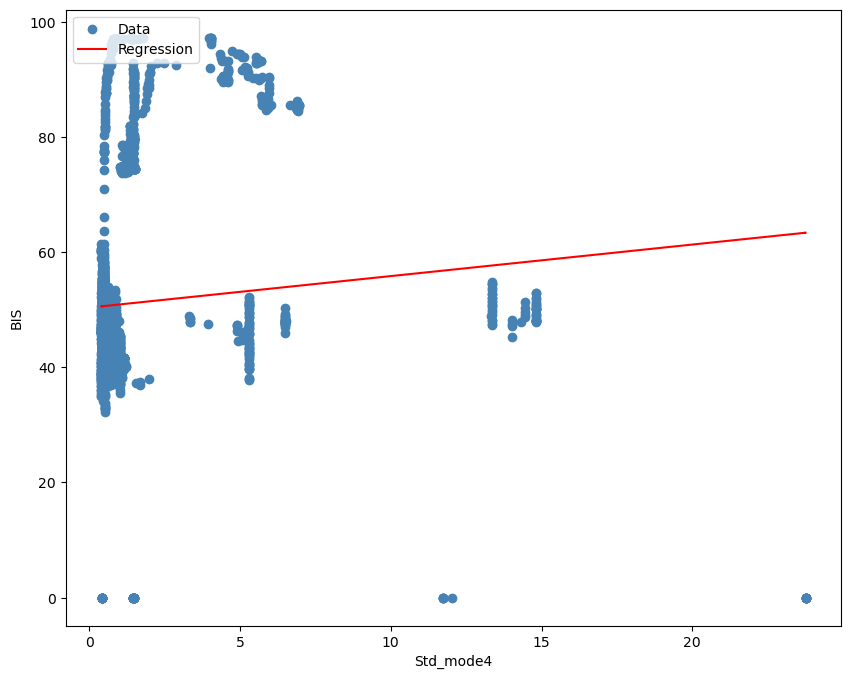

,Metrics,Values
0,Perment_mode3_r2,0.448004
1,Perment_mode4_r2,0.375346
2,Std_mode3_r2,0.000407
3,Std_mode2_r2,0.080889
4,Sampent_mode2_r2,0.040774
5,Sampent_mode3_r2,0.025021
6,Std_mode0_r2,0.002571
7,Std_mode1_r2,0.041282
8,Std_mode4_r2,0.007512


In [35]:
for column in df_std.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_std, column)
    
# Metrics
pd.DataFrame({"Metrics": [key for key in metrics.keys()], "Values": [value for value in metrics.values()]})

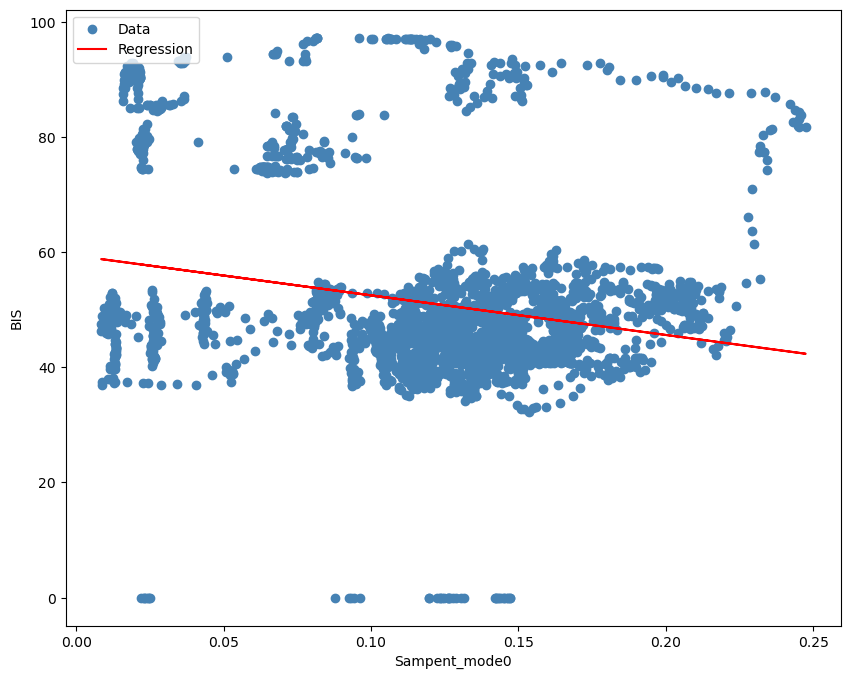

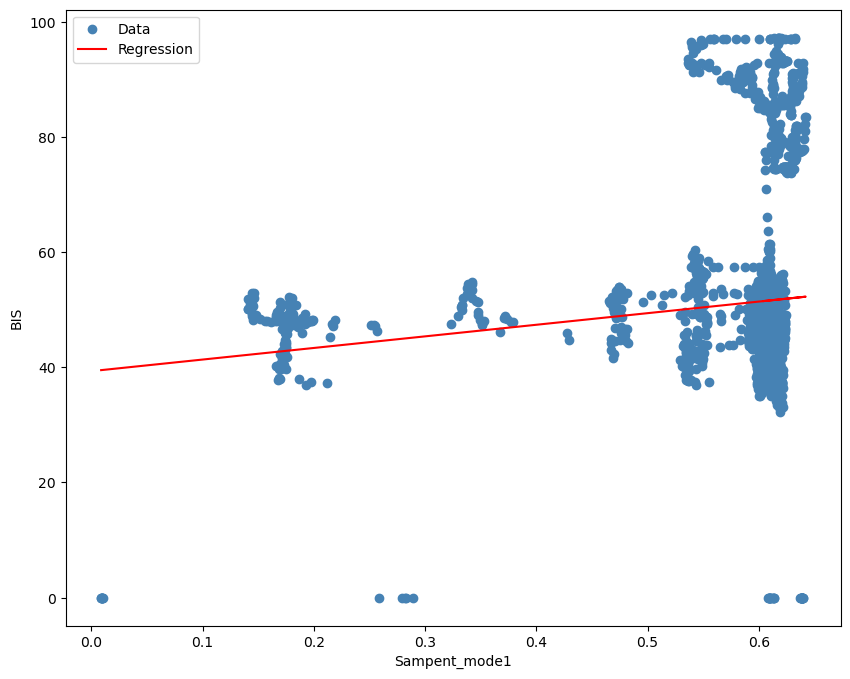

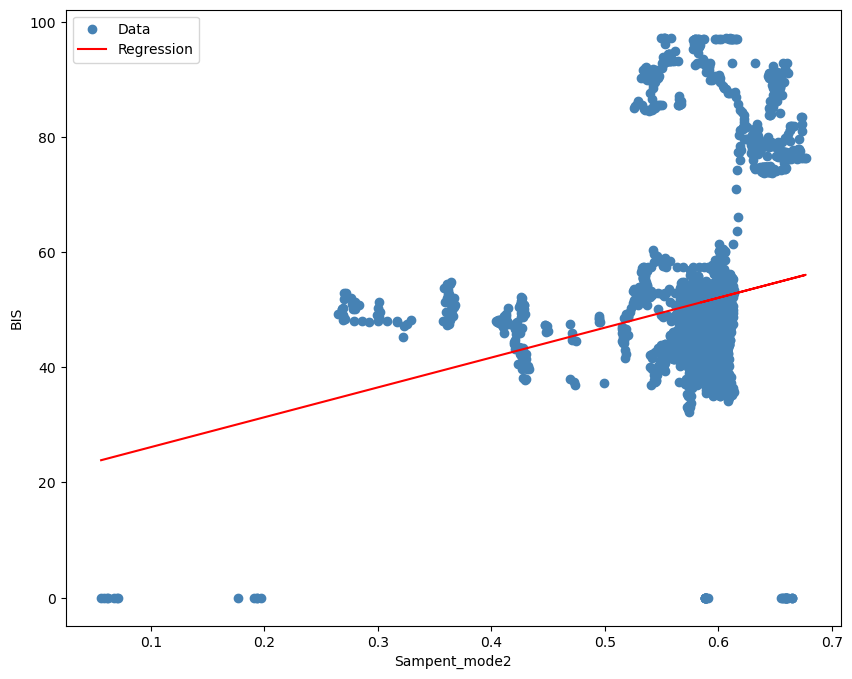

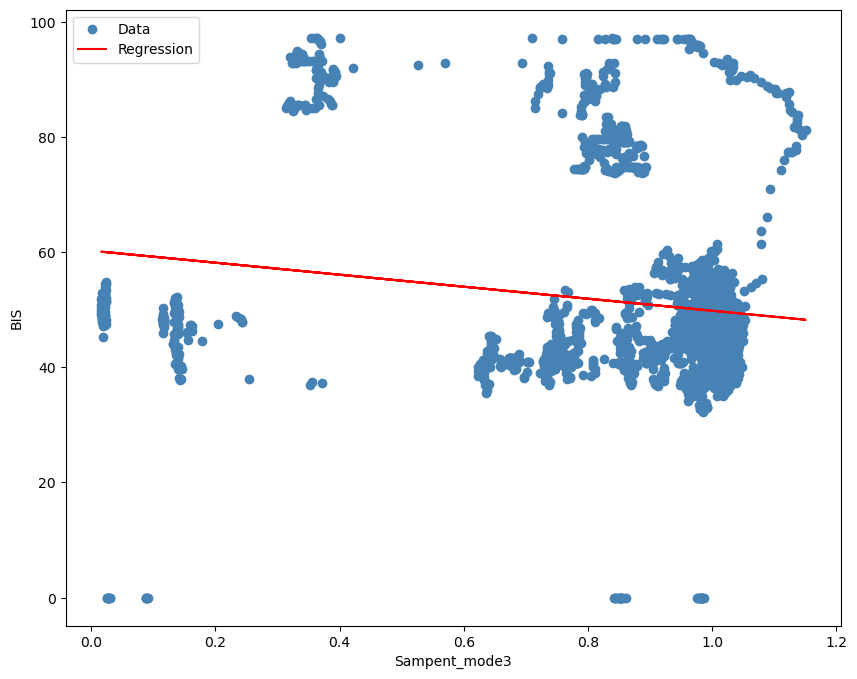

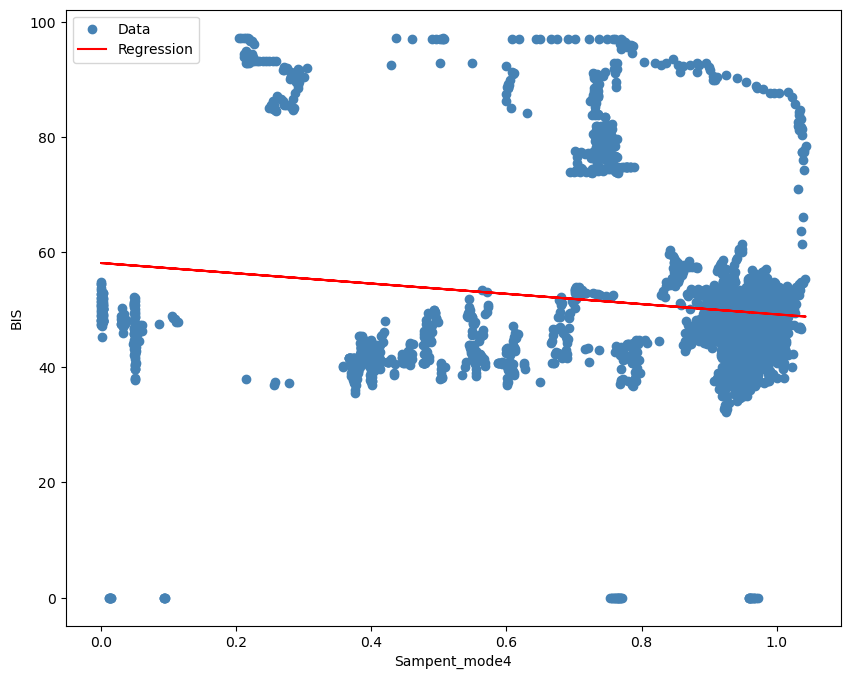

,Metrics,Values
0,Perment_mode3_r2,0.448004
1,Perment_mode4_r2,0.375346
2,Std_mode3_r2,0.000407
3,Std_mode2_r2,0.080889
4,Sampent_mode2_r2,0.040774
5,Sampent_mode3_r2,0.025021
6,Std_mode0_r2,0.002571
7,Std_mode1_r2,0.041282
8,Std_mode4_r2,0.007512
9,Sampent_mode0_r2,0.049634


In [36]:
for column in df_samp.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_samp, column)
    
# Metrics
pd.DataFrame({"Metrics": [key for key in metrics.keys()], "Values": [value for value in metrics.values()]})

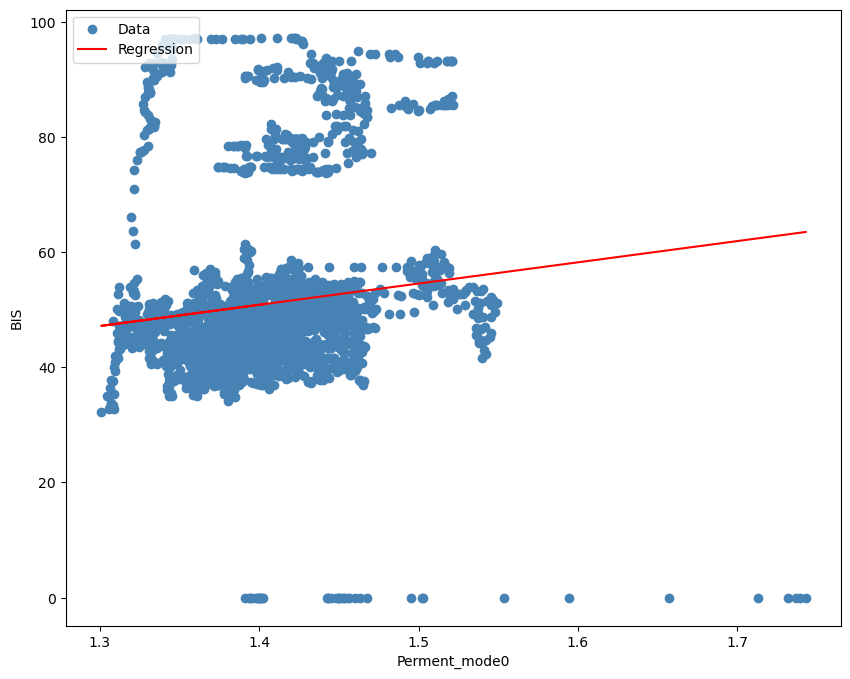

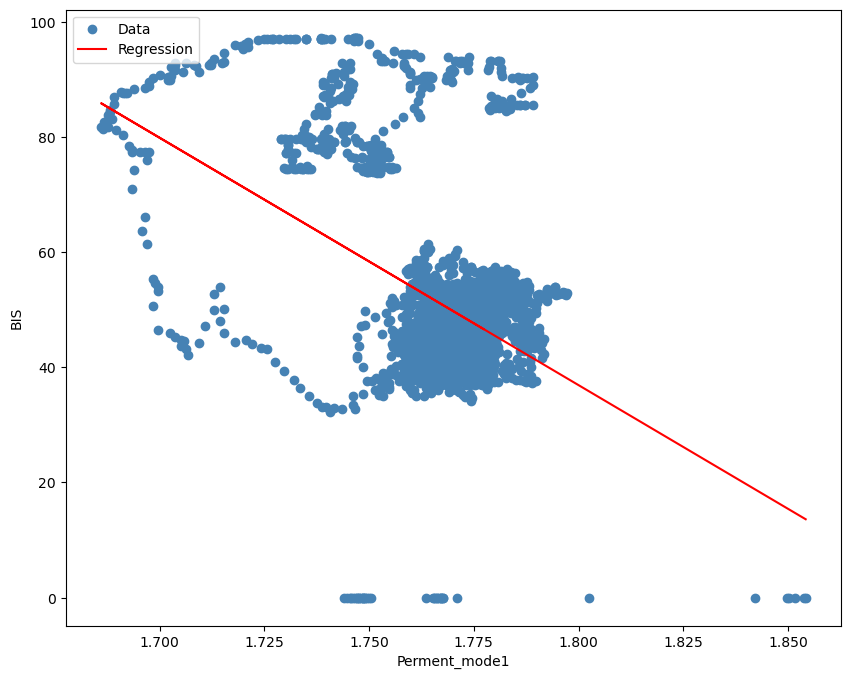

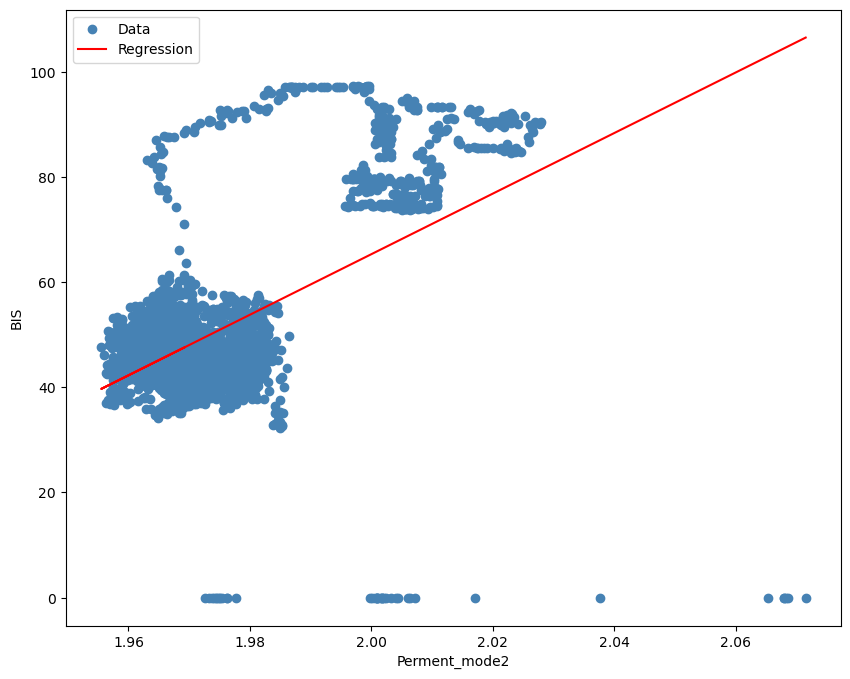

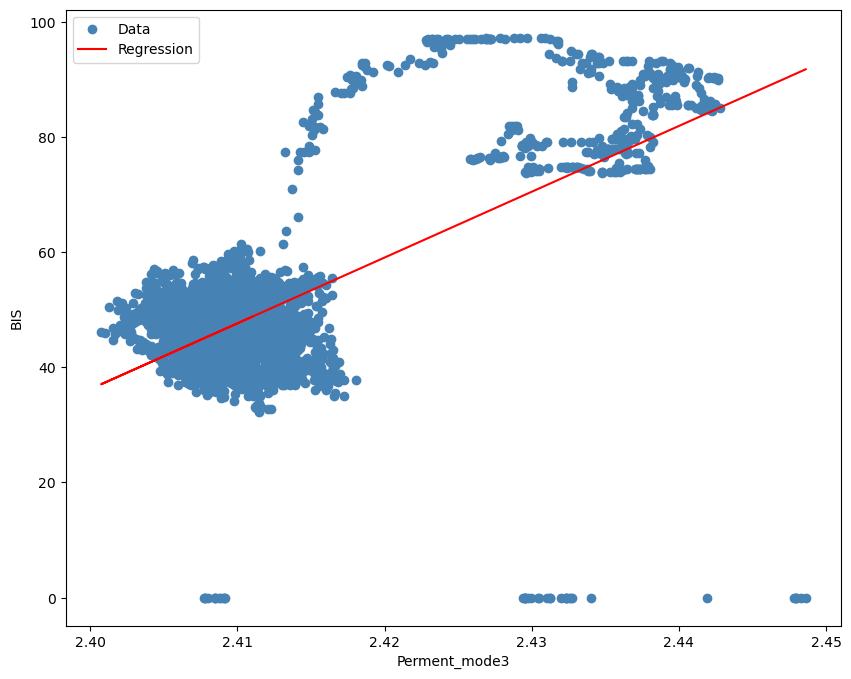

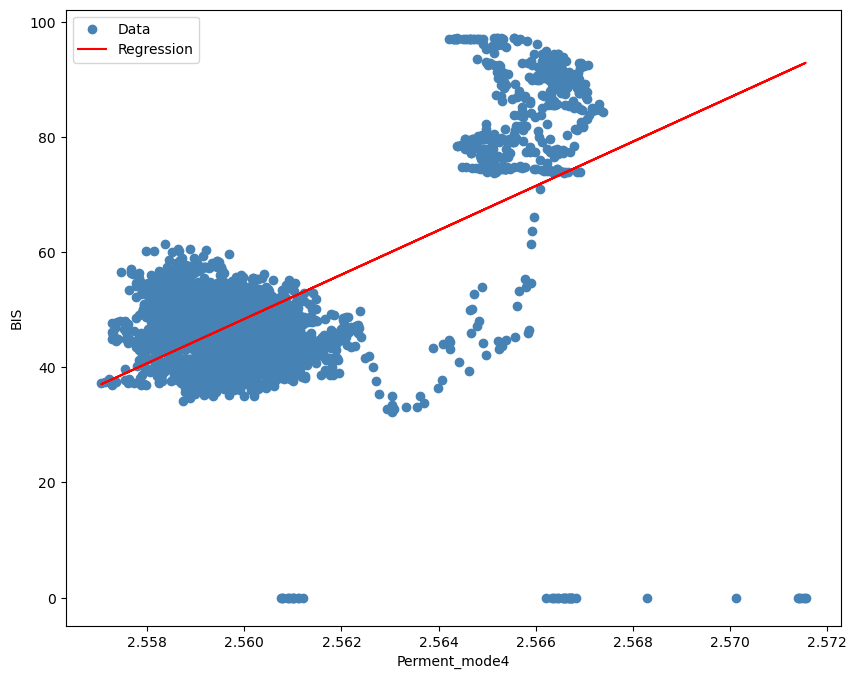

,Metrics,Values
0,Perment_mode3_r2,44.800434
1,Perment_mode4_r2,37.534642
2,Std_mode3_r2,0.040697
3,Std_mode2_r2,8.088898
4,Sampent_mode2_r2,4.077400
5,Sampent_mode3_r2,2.502117
6,Std_mode0_r2,0.257065
7,Std_mode1_r2,4.128157
8,Std_mode4_r2,0.751225
9,Sampent_mode0_r2,4.963438


In [52]:
for column in df_perm.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_perm, column)
    
# Metrics
pd.DataFrame({"Metrics": [key for key in metrics.keys()], "Values": [value*100 for value in metrics.values()]})

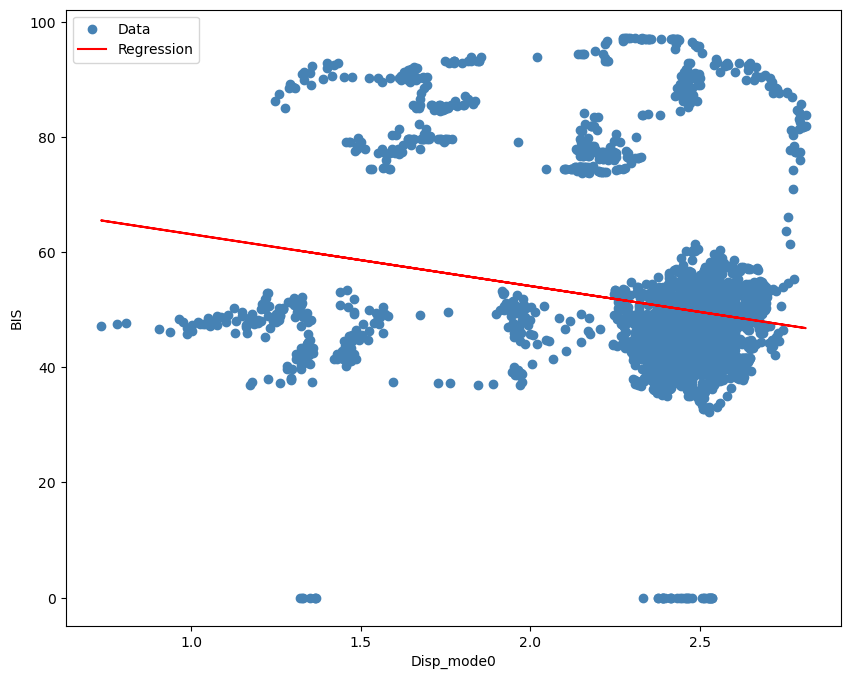

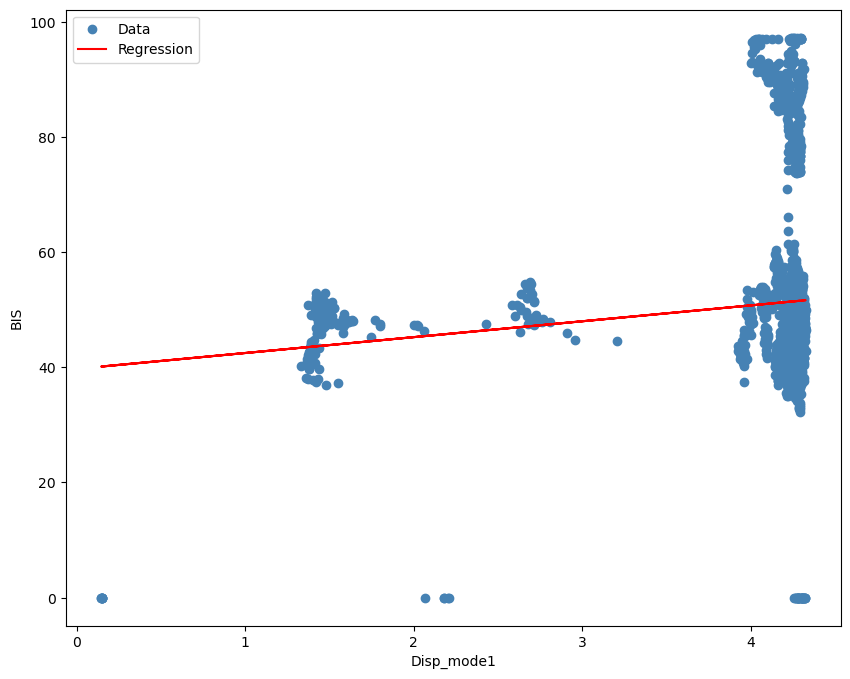

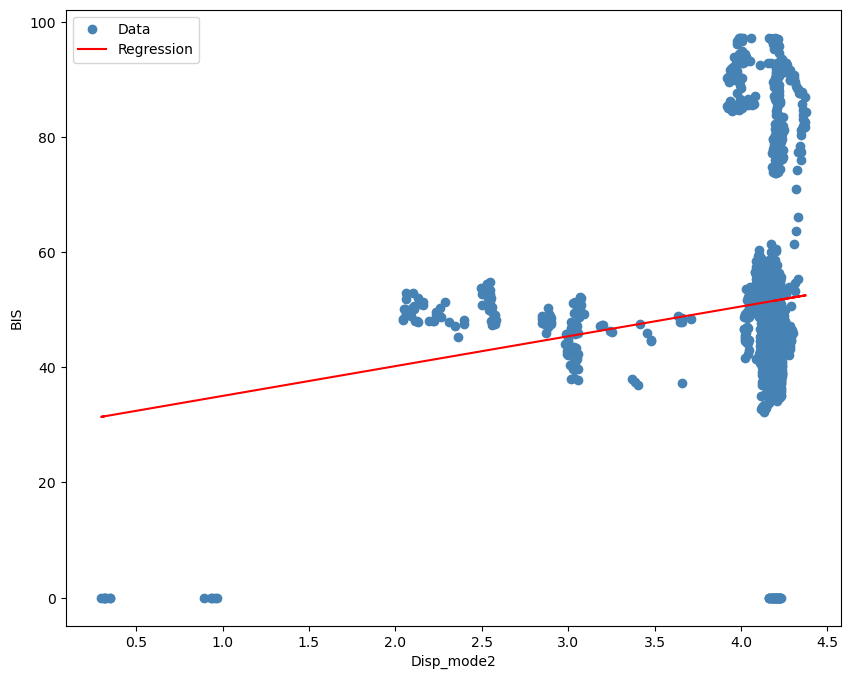

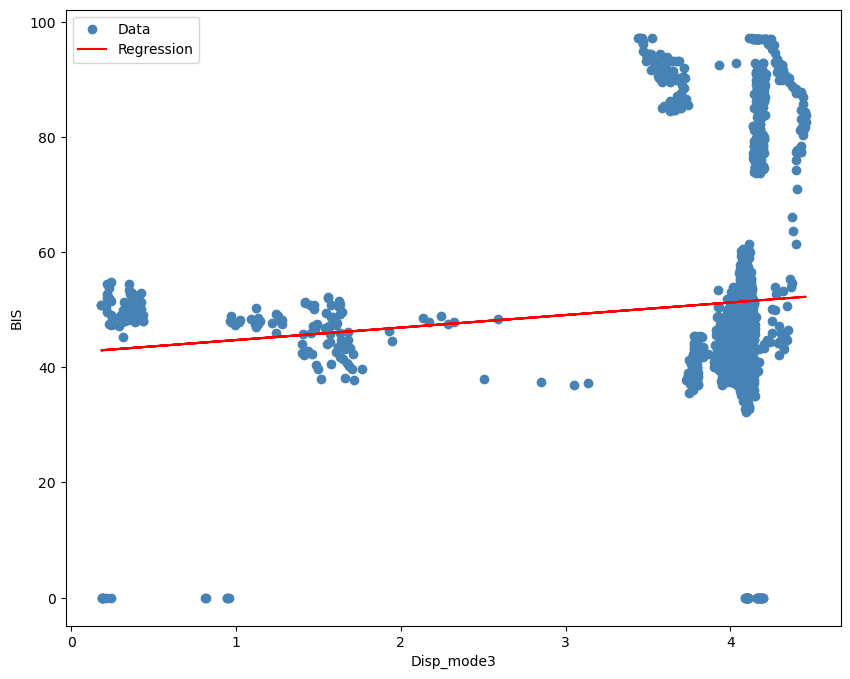

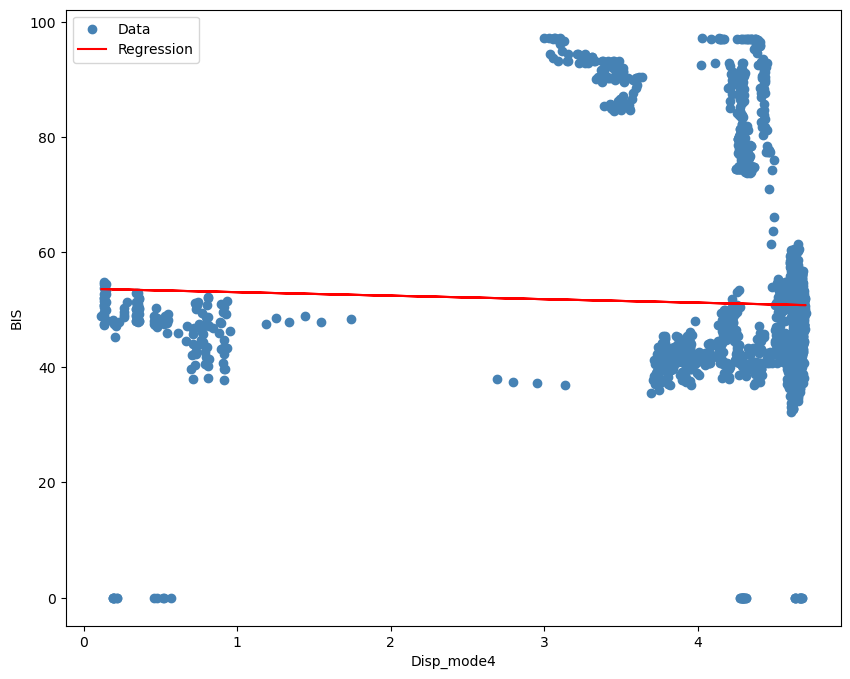

In [38]:
for column in df_disp.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_disp, column)
    
# Metrics
t=pd.DataFrame({"R_squared": [key for key in metrics.keys()], "Values": [value*100 for value in metrics.values()]})

In [39]:
# Metrics
res=pd.DataFrame({"R_squared": [key for key in metrics.keys()], "Values": [value*100 for value in metrics.values()]})
R=res['R_squared']
V=res["Values"]

Text(0.5, 1.0, 'R_squared Values')

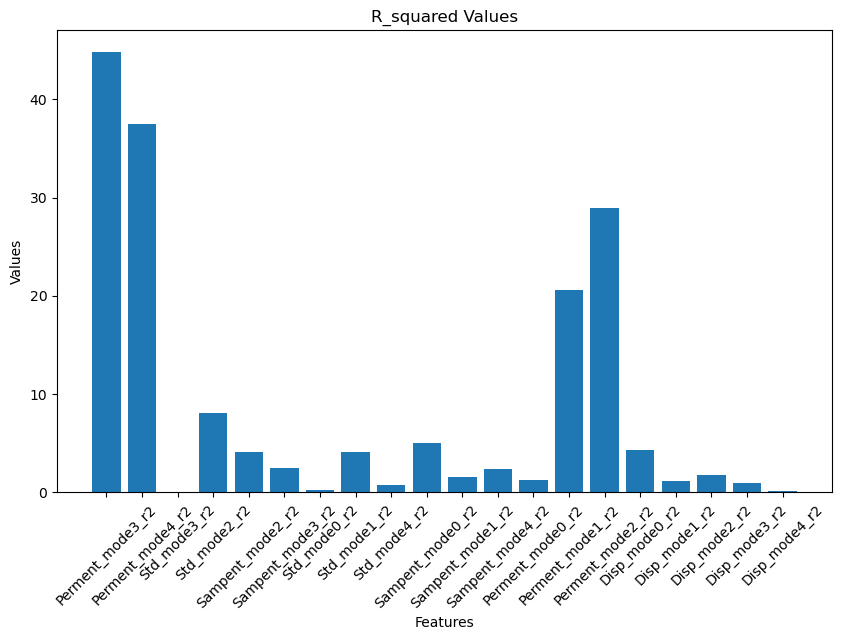

In [40]:
fig = plt.figure(figsize=(10, 6))
plt.bar(R, V)
plt.xticks(rotation=45)
plt.xlabel("Features")
plt.ylabel("Values")    
plt.title("R_squared Values")   

In [43]:
buk=pd.DataFrame({'Perment_mode4': resultsp_4,'Sampent_mode2': resultsa_2, 'Std_mode3': result_3})

In [45]:
combine=buk[['Perment_mode4', 'Sampent_mode2', 'Std_mode3']]
new_y=df_jo['BIS']


mm = LinearRegression(n_jobs=-1).fit(combine, new_y)
    
# Predictions
y_pre = mm.predict(combine)
    
# Show the score and r2
mse = mean_squared_error(new_y, y_pre)
r2 = r2_score(new_y, y_pre)
    

print("Multiple regression model Slope = %s, and intercept =%s"%(mm.coef_,mm.intercept_))
print('R_Squared_value for the multiple regression model: ', r2*100)

Multiple regression model Slope = [3.28510179e+03 1.08101392e+02 2.33076159e+00], and intercept =-8427.229749207048
R_Squared_value for the multiple regression model:  41.18446590173864


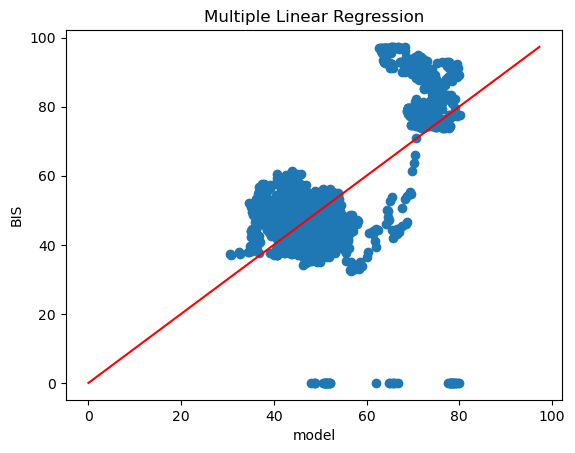

In [49]:
x1=buk['Perment_mode4']
x2=buk['Sampent_mode2']
x3=buk['Std_mode3']
y_plot =mm.coef_[0]*x1+mm.coef_[1]*x2+mm.coef_[2]*x3 + mm.intercept_

plt.scatter(y_plot, new_y)
plt.plot( [new_y.min(), new_y.max()], [new_y.min(), new_y.max()], label="Regression", c="red")

plt.title('Multiple Linear Regression')
plt.ylabel('BIS')
plt.xlabel('model')
plt.show()


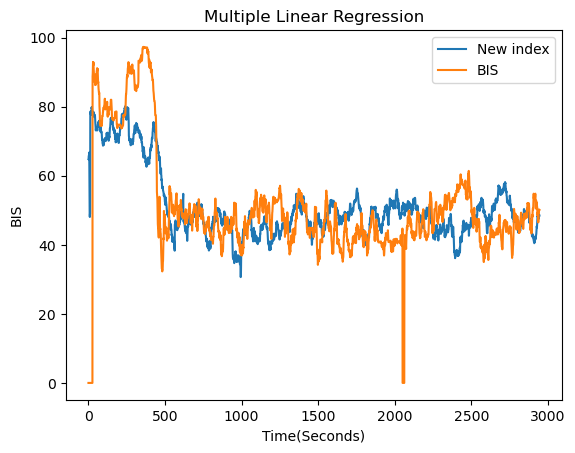

In [50]:
plt.plot(y_plot, label='New index')
plt.plot(new_y,label ="BIS")
plt.title('Multiple Linear Regression')
plt.ylabel('BIS')
plt.xlabel('Time(Seconds)')
plt.legend(loc="upper right")
plt.show()

In [61]:
buks=pd.DataFrame({'Perment_mode3': resultsp_3,'Sampent_mode0': resultsa_0, 'Std_mode2': result_2})

combines=buks[['Perment_mode3', 'Sampent_mode0', 'Std_mode2']]
new_y=df_jo['BIS']


mmm = LinearRegression(n_jobs=-1).fit(combines, new_y)
    
# Predictions
y_pre = mmm.predict(combines)
    
# Show the score and r2
mse = mean_squared_error(new_y, y_pre)
r2 = r2_score(new_y, y_pre)
    
    

print("Multiple regression model Slope = %s, and intercept =%s"%(mmm.coef_,mmm.intercept_))
print('R_Squared_value for the multiple regression model: ', r2*100)

Multiple regression model Slope = [ 1.06862060e+03 -1.22581867e+01 -5.21252072e-01], and intercept =-2523.827856599116
R_Squared_value for the multiple regression model:  45.37049083995813


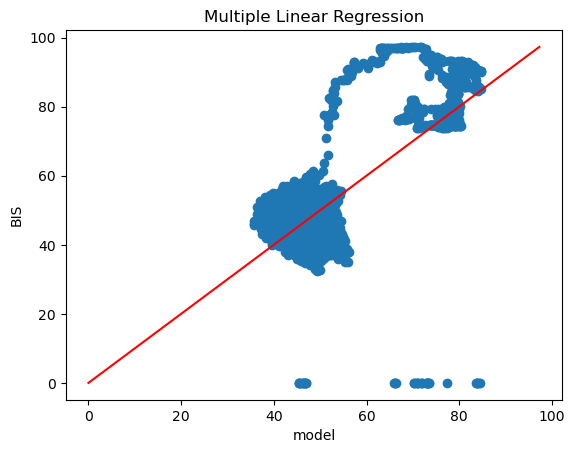

In [59]:
x1=buks['Perment_mode3']
x2=buks['Sampent_mode0']
x3=buks['Std_mode2']
y_plots =mmm.coef_[0]*x1+mmm.coef_[1]*x2+mmm.coef_[2]*x3 + mmm.intercept_

plt.scatter(y_plots, new_y)
plt.plot( [new_y.min(), new_y.max()], [new_y.min(), new_y.max()], label="Regression", c="red")

plt.title('Multiple Linear Regression')
plt.ylabel('BIS')
plt.xlabel('model')
plt.show()


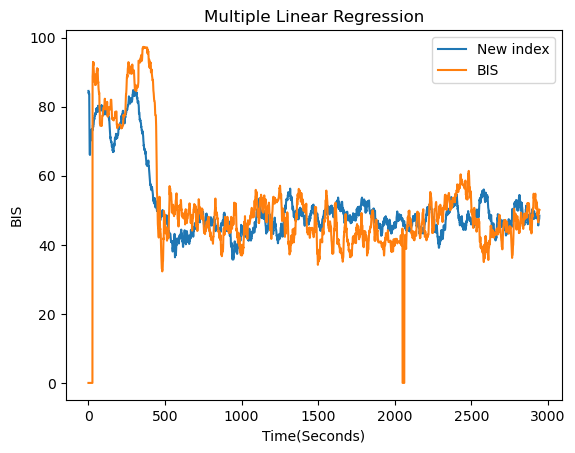

In [60]:
plt.plot(y_plots, label='New index')
plt.plot(new_y,label ="BIS")
plt.title('Multiple Linear Regression')
plt.ylabel('BIS')
plt.xlabel('Time(Seconds)')
plt.legend(loc="upper right")
plt.show()